In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.realpath(r'D:\code\Python-Project\文本数据挖掘\WBClassify')))
from WBClassify.Utils import utils
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.svm import SVC
import random
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'

In [2]:
def set_seed(seed=42):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
 
set_seed()

In [3]:
x_train,y_train,x_test,y_test,cut_words,encoder = utils.load_data2(method='jieba')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.622 seconds.
Prefix dict has been built successfully.


In [4]:
x_train

array(['九安 医疗 美国 躺 赚 董事长 疫情 结束 试剂盒 没人要 抢 时间 10% 公司',
       '亚 轨道 运输 新 技术 立项 未来 可一 小时 内 到达 全球 各地',
       '75 后 宁波 银 保监局 副局长 陈红 调任 安徽 银 保监局 纪委书记 金改 实验室', ...,
       '夜读 没什么 节日 饺子 解决不了',
       '海关总署 今年 前 11 月 我国 外贸 进出口 总值 同比 增长 8.6% 自贸区 连线',
       '中共中央 国务院 南京 举行 2022 年 南京大屠杀 死难者 国家 公祭 仪式 蔡奇 出席 讲话'], dtype=object)

In [5]:
x_train_count_,x_test_count_ = utils.pre_data(x_train,x_test,method='count',is_pca=False)       # 没有降维
x_train_tfidf_,x_test_tfidf_ = utils.pre_data(x_train,x_test,method='tfidf',is_pca=False)       # 没有降维

In [6]:
x_train_count,x_test_count = utils.pre_data(x_train,x_test,method='count',is_pca=True)
x_train_tfidf,x_test_tfidf = utils.pre_data(x_train,x_test,method='tfidf',is_pca=True)

In [7]:
x_train_count.shape,y_train.shape

((4000, 2936), (4000,))

In [8]:
encoder.classes_

array(['国际', '思想', '时事', '科技', '财经'], dtype=object)

In [9]:
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score as acc,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


def show_CM(cm,train,pred):
    cm = confusion_matrix(train,pred)
    cm = pd.DataFrame(cm,columns=5,index=5)
    sns.heatmap(cm, annot=True,fmt='.0f' ,cbar = False)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    sns.despine()
    

def train(x_train,y_train,x_test,y_test,model,is_showCM=False):
    if model.__module__ == 'sklearn.svm._classes':
        model.fit(x_train,y_train)
        train_pred = model.predict(x_train)
        test_pred = model.predict(x_test)
        print("训练集的准确度:",acc(y_train,train_pred))
        print("测试集的准确度:",acc(y_test,test_pred))
    else:
        model.fit(x_train,y_train)
        train_pred = np.argmax(model.predict_proba(x_train),axis=1)
        test_pred = np.argmax(model.predict_proba(x_test),axis=1)
        print("训练集的准确度:",acc(y_train,train_pred))
        print("测试集的准确度:",acc(y_test,test_pred))

    if is_showCM:
        train_cm = confusion_matrix(y_train,train_pred)
        train_cm = pd.DataFrame(train_cm,columns=encoder.classes_,index=encoder.classes_)
        test_cm = confusion_matrix(y_test,test_pred)
        test_cm = pd.DataFrame(test_cm,columns=encoder.classes_,index=encoder.classes_)
        fig, ax = plt.subplots(1,2, tight_layout = True, figsize = (15,5))
        
        sns.heatmap(train_cm, annot=True,fmt='.0f' ,cbar = False,ax=ax[0])
        sns.heatmap(test_cm, annot=True,fmt='.0f' ,cbar = False,ax=ax[1])
        ax[0].set_title('Train Confusion Matrix')
        ax[1].set_title('Test Confusion Matrix')
        ax[0].set_ylabel('Actual Values')
        ax[0].set_xlabel('Predicted Values')
        ax[1].set_xlabel('Predicted Values')
        sns.despine()

In [10]:
data_with_count = [x_train_count_,y_train,x_test_count_,y_test]
data_with_tfidf = [x_train_tfidf_,y_train,x_test_tfidf_,y_test]
data_with_count_pca = [x_train_count,y_train,x_test_count,y_test]
data_with_tfidf_pca = [x_train_tfidf,y_train,x_test_tfidf,y_test]

## 贝叶斯模型

In [11]:
NB = MultinomialNB()

词袋表示法：
训练集的准确度: 0.97625
测试集的准确度: 0.849
tdidf表示：
训练集的准确度: 0.97275
测试集的准确度: 0.843


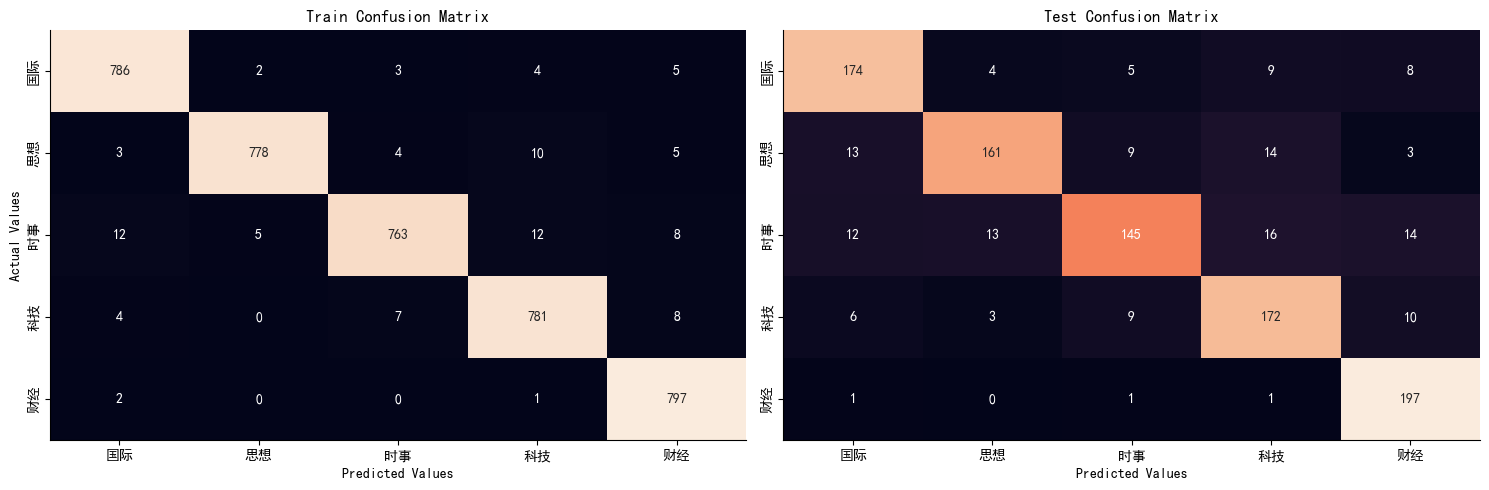

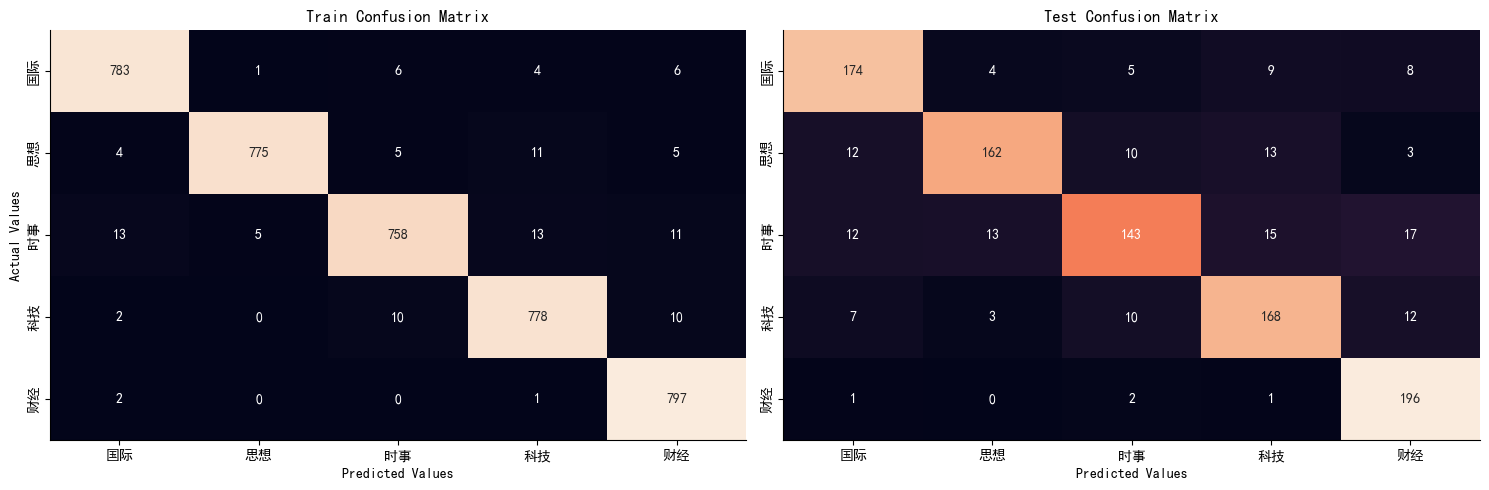

In [12]:
print("词袋表示法：")
train(*data_with_count,NB,is_showCM=True)
print("tdidf表示：")
train(*data_with_tfidf,NB,is_showCM=True)

交叉验证——词袋表示法：
训练集的准确度: 0.98025
测试集的准确度: 0.861
交叉验证——tdidf表示：
训练集的准确度: 0.97225
测试集的准确度: 0.857


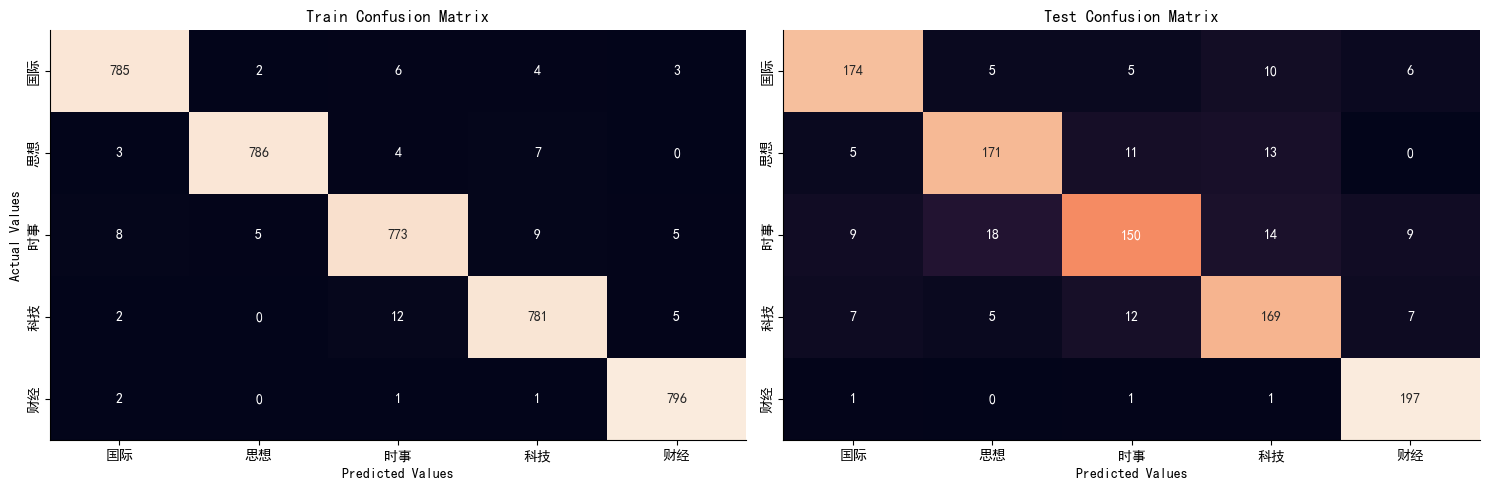

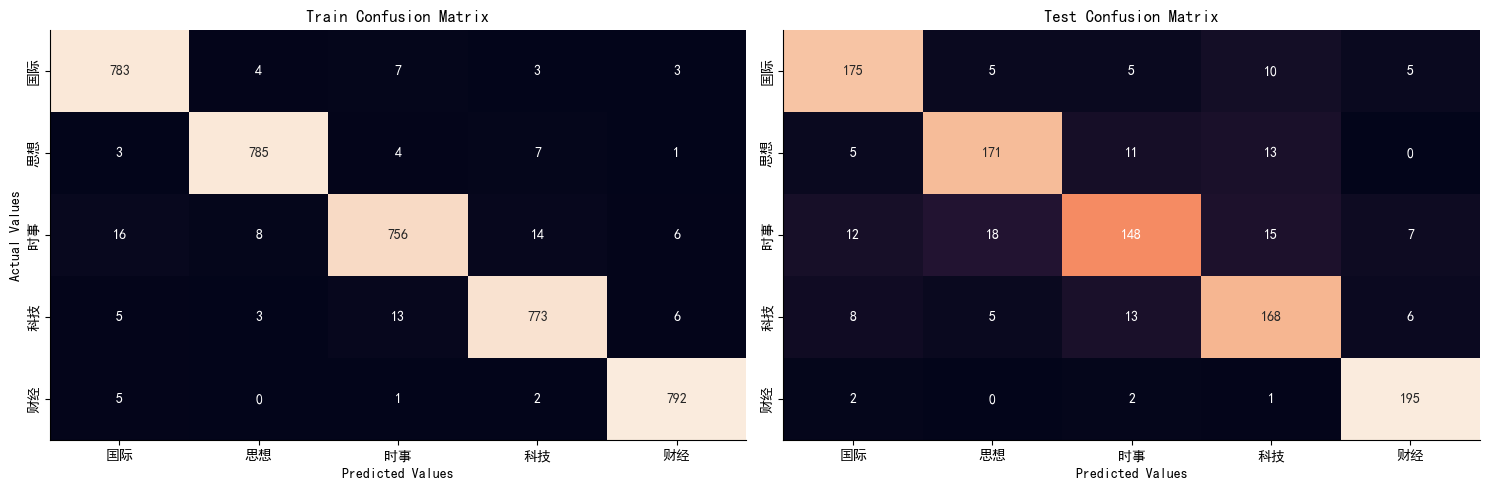

In [13]:
from sklearn.calibration import CalibratedClassifierCV
model = CalibratedClassifierCV(MultinomialNB(), cv=5, method='isotonic')
print("交叉验证——词袋表示法：")
train(*data_with_count,model,is_showCM=True)
print("交叉验证——tdidf表示：")
train(*data_with_tfidf,model,is_showCM=True)

## 集成模型LGB

In [14]:
lgb = LGBMClassifier(n_estimators=3000,max_depth=6,num_leaves=2**6,subsample=0.9,reg_lambda=0.2,learning_rate=0.01)

In [15]:
train(*data_with_count,lgb)
train(*data_with_tfidf,lgb)

训练集的准确度: 0.761
测试集的准确度: 0.718
训练集的准确度: 0.7945
测试集的准确度: 0.696


在进行支持向量机的操作时出现了运行不玩的情况，担当把函数拆开又可以运行